#### data preprocessing 

In [58]:
# data split
# split_data.py

import os
import pickle
import glob
import numpy as np

def split_data():
    data_root_path = './data/IN792sx/gamma/annotations/'
    save_path = './data/IN792sx/gamma/'
    train_test_split_(data_root_path, save_path)
   
def train_test_split_(path, save_path):
    data_list = glob.glob(path+'*.*')
      
    indices = np.random.choice(['train', 'test'], p=[.9, .1], size=len(data_list))
    train_list = []
    test_list = []
    
    
    for i in range(len(data_list)):
        if indices[i] == 'train':
            train_list.append(data_list[i].split('\\')[-1])

        elif indices[i] == 'test':
            test_list.append(data_list[i].split('\\')[-1])

    with open(os.path.join(save_path, 'train.txt'), 'wb') as t:
        pickle.dump(train_list, t)

    with open(os.path.join(save_path, 'test.txt'), 'wb') as v:
        pickle.dump(test_list, v)
    
    print('total len of data : ', len(data_list))
    print('========================================')
    print('example of train data : ', train_list[0])
    print('len of train data : ', len(train_list))
    print('========================================')
    print('example of test data : ', test_list[0])
    print('len of test data : ', len(test_list))


split_data()


total len of data :  52
example of train data :  210324-409-1_m001_r1.png
len of train data :  49
example of test data :  210330-411-1_m003_r1.png
len of test data :  3


In [59]:
# data cropping
# random_crop.py
import os
import argparse
from PIL import Image
import pickle
from random import randrange
from pathlib import Path

def random_crop():
    data = 'IN792sx'
    data_root_path = './data/IN792sx/gamma/'
    save_img = './data/IN792sx/gamma/img_random'
    save_msk = './data/IN792sx/gamma/msk_random'

    train_random_crop(data_root_path, save_img, save_msk)

def train_random_crop(data_root_path, save_img, save_msk): 
    
    with open(os.path.join(data_root_path, 'train.txt'), 'rb') as f:
        data_list = pickle.load(f)

    img_path = os.path.join(data_root_path, 'images')
    mask_path = os.path.join(data_root_path, 'annotations')

    save_img = Path(save_img)
    save_img.mkdir(parents=True, exist_ok=True)

    save_msk = Path(save_msk)
    save_msk.mkdir(parents=True, exist_ok=True)


    new_img_list = []
    
    for name in data_list:
        name = name.split(' ')[0]
        img = Image.open(os.path.join(img_path, name))
        mask = Image.open(os.path.join(mask_path, name))

        x, y = img.size
        
        matrix_w = 640
        matrix_h = 448
            
        sample = 5

        for i in range(sample):
            x1 = randrange(0, x - matrix_w)
            y1 = randrange(0, y - matrix_h)
            new_img = img.crop((x1, y1, x1 + matrix_w, y1 + matrix_h))
            new_msk = mask.crop((x1, y1, x1 + matrix_w, y1 + matrix_h))
            new_name = name[:-4] + '_' + str(i) + '.png'
            new_img_list.append(new_name)
            new_img.save(os.path.join(save_img, new_name))
            new_msk.save(os.path.join(save_msk, new_name))

    with open(os.path.join(data_root_path, 'images_random.txt'), 'wb') as f:
        pickle.dump(new_img_list, f)
    
    print('total len of data : ', len(new_img_list))
    print('example of train data : ', new_img_list[0])
   
random_crop()

total len of data :  245
example of train data :  210324-409-1_m001_r1_0.png


In [60]:
# train and validation
# main.py

parser = argparse.ArgumentParser(description='sem img segmenation')

parser.add_argument('--data', type=str, default='IN792sx', help=" IN792sx | IN792sx_inter | CM939W")
parser.add_argument('--data_root_path', type=str, default='./data/IN792sx/gamma/')
parser.add_argument('--image_path', type=str, default='./data/IN792sx/gamma/img_random')
parser.add_argument('--mask_path', type=str, default='./data/IN792sx/gamma/msk_random')
parser.add_argument('--save_dir', type=str, default='./history/230719/IN792sx/')
parser.add_argument('--exp_name', type=str, default='resnet18_4_32')

parser.add_argument('--batch_size', type=int, default=2)
parser.add_argument('--num_worker', type=int, default=0)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=1)
parser.add_argument('--ckpt_interval', type=int, default=1)
parser.add_argument('--ckpt_save', type=int, default=10)

args = parser.parse_args(list())



In [61]:
def train_val_split_(path):

    with open(os.path.join(path,'images_random.txt'), 'rb') as f:
        data = pickle.load(f)

      
    indices = np.random.choice(['train', 'valid'], p=[.9, .1], size=len(data))
    train_list = []
    val_list = []
    
    
    for i in range(len(data)):
        if indices[i] == 'train':
            train_list.append(data[i])

        elif indices[i] == 'valid':
            val_list.append(data[i])

    with open(os.path.join(path, 'train_random.txt'), 'wb') as t:
        pickle.dump(train_list, t)

    with open(os.path.join(path, 'val_random.txt'), 'wb') as v:
        pickle.dump(val_list, v)


    print('example of train data : ', train_list[0])
    print('len of train data : ', len(train_list))
    print('========================================')
    print('example of val data : ', val_list[0])
    print('len of val data : ', len(val_list))

    return train_list[0], val_list[0]

train_name, val_name = train_val_split_(args.data_root_path)


example of train data :  210324-409-1_m001_r1_1.png
len of train data :  221
example of val data :  210324-409-1_m001_r1_0.png
len of val data :  24


(640, 448)


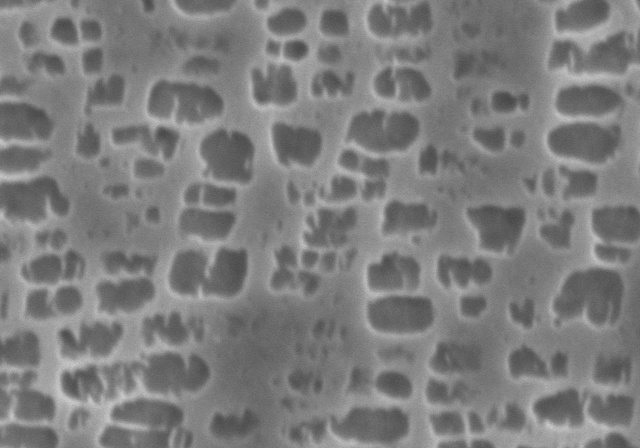

In [62]:
from PIL import Image
img_vis = Image.open(os.path.join(args.image_path, train_name)).convert("L")
print(img_vis.size)
img_vis


(640, 448)


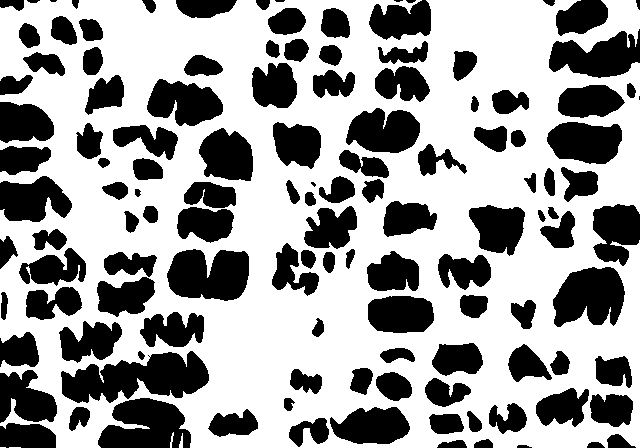

In [63]:
msk_vis = Image.open(os.path.join(args.mask_path, train_name)).convert("L")
print(msk_vis.size)
msk_vis

In [64]:

# dataset.py

import cv2
import os
import numpy as np
import pickle
from PIL import Image
import glob
import random
from random import randint

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T

from utils.pre_processing import *
from utils.mean_std import *

class CustomDatasetTrain(Dataset):

    def __init__(self, image_path, mask_path):
        """
        Args:
            image_path (str): the path where the image is located
            mask_path (str): the path where the mask is located
            option (str): decide which dataset to import
        """
        # all file names
        self.image_path = image_path
        self.mask_path = mask_path
        self.data_list = self.__read_data__()

        # Calculate len
        self.data_len = len(self.data_list)

    def __getitem__(self, index):
        """Get specific data corresponding to the index
        Args:
            index (int): index of the data
        Returns:
            Tensor: specific data on index which is converted to Tensor
        """
        """
        # GET IMAGE
        """
        # eta_list = ['210415-AC1-1_m001_r1', '210415-AC1-1_m002_r1', '210415-AC1-1_m003_r1']
        single_image_name = self.data_list[index]
        img_as_img = Image.open(os.path.join(self.image_path, single_image_name)).convert("L")

        if randint(0,1):
            sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=10)
            img_as_img = sharpness_adjuster(img_as_img)

        img_as_np = np.asarray(img_as_img)
      
        flip_num = randint(0, 3)
        img_as_np = flip(img_as_np, flip_num)

        # # Noise Determine {0: Gaussian_noise, 1: uniform_noise
        if randint(0, 1):
            # Gaussian_noise
            gaus_sd, gaus_mean = randint(0, 20), 0
            img_as_np = add_gaussian_noise(img_as_np, gaus_mean, gaus_sd)
        else:
            # uniform_noise
            l_bound, u_bound = randint(-20, 0), randint(0, 20)
            img_as_np = add_uniform_noise(img_as_np, l_bound, u_bound)

        
        # Brightness
        pix_add = randint(-20, 20)
        img_as_np = change_brightness(img_as_np, pix_add)

        """
        # GET MASK
        """
        single_mask_name = self.data_list[index]
        msk_as_img = Image.open(os.path.join(self.mask_path, single_mask_name)).convert("L")
        msk_as_np = np.asarray(msk_as_img)

        # flip the mask with respect to image
        msk_as_np = flip(msk_as_np, flip_num)
        

        # Normalize the image
        img_as_np = normalization2(img_as_np, max=1, min=0)
        img_as_np = np.expand_dims(img_as_np, axis=0)  # add additional dimension
        img_as_tensor = torch.from_numpy(img_as_np).float()  # Convert numpy array to tensor

        # Normalize mask to only 0 and 1
        msk_as_np = msk_as_np/255
        msk_as_tensor = torch.from_numpy(msk_as_np).long()  # Convert numpy array to tensor

        return self.data_list[index], img_as_tensor, msk_as_tensor
    

    def __len__(self):
        """
        Returns:
            length (int): length of the data
        """
        return self.data_len

    def __read_data__(self):
        
        name = 'train_random.txt'

        root_path = '/'.join(self.image_path.split('/')[:-1])
        with open(os.path.join(root_path, name), 'rb') as f:
            data_list = pickle.load(f)
       
        return data_list
    

class CustomDatasetVal(Dataset):
    def __init__(self, image_path, mask_path):
        '''
        Args:
            image_path = path where test images are located
            mask_path = path where test masks are located
        '''
        # paths to all images and masks
        self.image_path = image_path
        self.mask_path = mask_path
        self.data_list = self.__read_data__()
        self.data_len = len(self.data_list)

    def __getitem__(self, index):
        """Get specific data corresponding to the index
        Args:
            index : an integer variable that calls (indext)th image in the
                    path
        Returns:
            Tensor: 4 cropped data on index which is converted to Tensor
        """
        eta_list = ['210415-AC1-1_m001_r1', '210415-AC1-1_m002_r1', '210415-AC1-1_m003_r1']
        
        single_image = self.data_list[index]
        
        # if single_image.split('.')[0] in eta_list:
        #     label = torch.FloatTensor([1])
        # else:
        #     label = torch.FloatTensor([0])

        
        img_as_img = Image.open(os.path.join(self.image_path, single_image)).convert("L")
        
        # if randint(0,1):
        #     rotater = T.RandomRotation(degrees=(0, 180))
        #     img_as_img = rotater(img_as_img)
        # if randint(0,1):
        #     sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=2)
        #     img_as_img = sharpness_adjuster(img_as_img)

        # Convert the image into numpy array
        img_as_np = np.asarray(img_as_img)
        
        # Median blur
        # img_as_np = cv2.medianBlur(img_as_np, 11)

        # Otsu binary
        # otsu_threshold, image_result = cv2.threshold(img_as_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # th, dst = cv2.threshold(img_as_np, otsu_threshold, 255, cv2.THRESH_BINAR)

        """
        # GET MASK
        """
        single_mask_name = self.data_list[index]
        msk_as_img = Image.open(os.path.join(self.mask_path, single_mask_name)).convert("L")
        # msk_as_img = msk_as_img.resize((512,512))
            # msk_as_img.show()
        msk_as_np = np.asarray(msk_as_img)
        
        
        # for array in img_as_np:
            # Normalize the cropped arrays
        img_as_np = normalization2(img_as_np, max=1, min=0)
            # Convert normalized array into tensor
            # processed_list.append(img_to_add)

        img_as_tensor = torch.Tensor(img_as_np)
        
        msk_as_np = msk_as_np/255

        msk_as_tensor = torch.from_numpy(msk_as_np).long()  # Convert numpy array to tensor
        original_msk = torch.from_numpy(np.asarray(msk_as_img))
        return img_as_tensor, msk_as_tensor, original_msk, single_image
    

    def __read_data__(self):
        
        name = 'val_random.txt'
            
        root_path = '/'.join(self.image_path.split('/')[:-1])
        
        with open(os.path.join(root_path, name), 'rb') as f:
            data_list = pickle.load(f)
       
        return data_list

    def __len__(self):

        return self.data_len


In [65]:
trainset = CustomDatasetTrain(args.image_path, args.mask_path)

In [66]:
train_img_name, train_img, train_msk = trainset.__getitem__(1)
print(train_img_name)
print(train_img)
print(train_img.shape)
print(train_msk)
print(train_msk.shape)

210324-409-1_m001_r1_2.png
tensor([[[0.3894, 0.3186, 0.2699,  ..., 0.3496, 0.3496, 0.4779],
         [0.2965, 0.1726, 0.3230,  ..., 0.3407, 0.3673, 0.3142],
         [0.4204, 0.3894, 0.2788,  ..., 0.5354, 0.5442, 0.2566],
         ...,
         [0.4956, 0.4292, 0.4469,  ..., 0.5265, 0.6460, 0.6814],
         [0.4912, 0.4956, 0.3761,  ..., 0.4779, 0.6239, 0.5531],
         [0.5177, 0.5221, 0.5973,  ..., 0.3496, 0.5752, 0.4867]]])
torch.Size([1, 448, 640])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
torch.Size([448, 640])


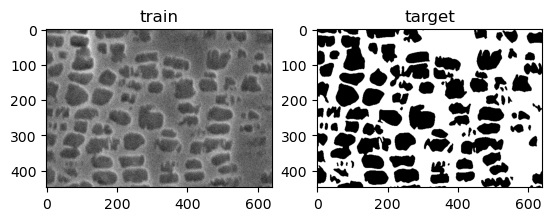

In [67]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# pil_train_img = to_pil_image(train_img)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(train_img), cmap='gray')
plt.title('train')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(train_msk.numpy().astype(np.uint8)), cmap='gray')
plt.title('target')

pil_train_img = to_pil_image(train_img)



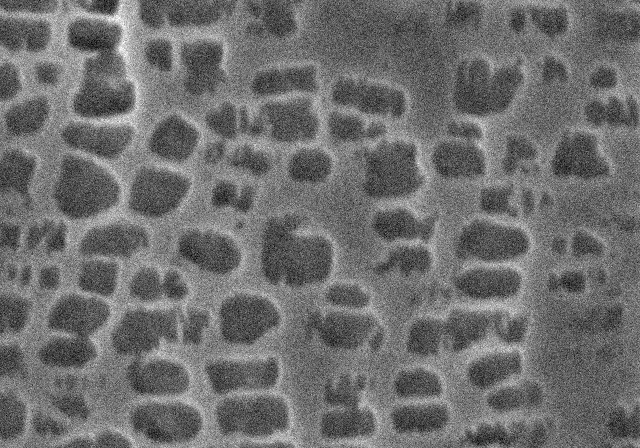

In [68]:
pil_train_img = to_pil_image(train_img)
pil_train_img

In [69]:
valset = CustomDatasetVal(args.image_path, args.mask_path) 

In [70]:
save_path = os.path.join(args.save_dir, args.exp_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

SEM_train_load = torch.utils.data.DataLoader(dataset=trainset,
                                                num_workers=args.num_worker, 
                                                batch_size=args.batch_size, 
                                                shuffle=True)
SEM_val_load = torch.utils.data.DataLoader(dataset=valset,
                                            num_workers=args.num_worker,
                                            batch_size=1, 
                                            shuffle=False)

In [71]:
import segmentation_models as smp
from utils.accuracy import accuracy_check, accuracy_check_for_batch
from utils.save_history import save_prediction_image
from modules import train_model, validate_model

model = smp.DeepLabV3('resnet34', encoder_depth=4, encoder_weights=None, in_channels=1, decoder_channels=32)

In [72]:
model

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

**model architecture**  
encoder  
![image1.png](../img/resnet.png)  
decoder  
![image2.png](../img/segmentation.png)

In [73]:
model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# Saving History to csv
header = ['epoch', 'train loss', 'train acc', 'val loss', 'val acc']

fn_loss = nn.BCEWithLogitsLoss()

In [ ]:
# modules.py

import csv
import os
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torch.nn as nn

from utils.accuracy import accuracy_check, accuracy_check_for_batch
from utils.save_history import save_prediction_image

def train_model(epoch, model, data_train, criterion, optimizer):

    """Train the model and report training error with accuracy

    Args:
        epoch: epoch
        model: the model to be trained
        data_train(DataLoader): training dataset
        criterion: loss function
        optimizer: optimizer

    Retrun:
        total loss: loss value for training dataset
        total acc: accuracy value for training dataset
    """

    total_acc = 0
    total_loss = 0
    batches = 0

    model.train()

    for batch, (name, images, masks) in enumerate(data_train):

        images = Variable(images.cuda(), requires_grad=True) 
        masks = Variable(masks.cuda())
       
        b, h, w = masks.shape
        tmp_masks = (masks.clone().detach().view(b,1,h,w)).type(torch.float)
        
        outputs, encoder_features, decoder_output = model(images)
        
        loss = criterion(outputs, tmp_masks)

        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()
        acc = accuracy_check_for_batch(tmp_masks.cpu(), outputs.cpu(), images.size()[0])
        total_acc = total_acc + acc
        total_loss = total_loss + loss.cpu().item()

        if (batch+1) % 5 == 0:
            print('Epoch', str(epoch+1), 'Train loss:', loss.item(), "Train acc", acc)

    return total_loss/len(data_train), total_acc/len(data_train)

def validate_model(epoch, model, data_val, criterion, make_prediction=True, save_dir='prediction'):
    """Validate the model and report validation error with accuracy

    Args:
        epoch: epoch
        model: the trained model
        data_val(DataLoader): validation dataset
        criterion: loss function
        make_prediction: flag of the saving prediction images
        save_dir: saving the prediction images folder

    Retrun:
        total loss: loss value for validation dataset
        total acc: accuracy value for validation dataset
    """
    # calculating validation loss
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    minmax_scaler = MinMaxScaler()
    for batch, (image, mask, original_msk, name) in enumerate(data_val):
        
        with torch.no_grad():
            
            image = Variable(image.unsqueeze(0).cuda())
            mask = Variable(mask.cuda())
        
            b, h, w = mask.shape
            tmp_mask = (mask.clone().detach().view(b,1,h,w)).type(torch.float)
            output, _, _ = model(image)
    
            loss = criterion(output, tmp_mask)
            total_val_loss = total_val_loss + loss.cpu().item()

            result = minmax_scaler.fit_transform(output[0][0].cpu())
            result[result < 0.5] = 0
            result[result >= 0.5] = 255

            gt_msk = minmax_scaler.fit_transform(tmp_mask[0][0].cpu())
            gt_msk[gt_msk < 0.5] = 0
            gt_msk[gt_msk >= 0.5] = 255

            acc_val = accuracy_check(gt_msk, result)
            total_val_acc = total_val_acc + acc_val

        if make_prediction:
            im_name = name 
            pred_msk = save_prediction_image(result, im_name, epoch, save_dir)

    return total_val_loss/len(data_val), total_val_acc/len(data_val)



In [74]:
best_val_acc = 0
print("Initializing Training!") 
for i in range(0, args.epochs):
    # # train the model
    train_loss, train_acc = train_model(i, model, SEM_train_load, fn_loss, optimizer)
    # # # # Validation every 5 epoch
    if (i+1) % args.ckpt_interval == 0:
        val_loss, val_acc = validate_model(
            i+1, model, SEM_val_load, fn_loss, True, save_path)
        print('Val loss:', val_loss, "val acc:", val_acc)
        values = [i+1, train_loss, train_acc, val_loss, val_acc]
        export_history(header, values, save_path)

        if best_val_acc <= val_acc :  
            best_val_acc = val_acc
            save_models(model, save_path, i+1, True)

    if (i+1) % args.ckpt_save == 0: 
        save_models(model, save_path, i+1)
    

Initializing Training!


Epoch 1 Train loss: 0.6985328793525696 Train acc 0.49005126953125
Epoch 1 Train loss: 0.6682462096214294 Train acc 0.4400617327008929
Epoch 1 Train loss: 0.6526438593864441 Train acc 0.45314767020089286
Epoch 1 Train loss: 0.6049996018409729 Train acc 0.5904174804687501
Epoch 1 Train loss: 0.5599636435508728 Train acc 0.6672380719866071
Epoch 1 Train loss: 0.5788171887397766 Train acc 0.5732282366071428
Epoch 1 Train loss: 0.5422249436378479 Train acc 0.6275303431919643
Epoch 1 Train loss: 0.4991793930530548 Train acc 0.6972028459821429
Epoch 1 Train loss: 0.487579882144928 Train acc 0.7290509905133928
Epoch 1 Train loss: 0.4517548382282257 Train acc 0.7471208844866071
Epoch 1 Train loss: 0.4417186975479126 Train acc 0.8137451171875
Epoch 1 Train loss: 0.4680347442626953 Train acc 0.7529244559151786
Epoch 1 Train loss: 0.4460564851760864 Train acc 0.77744140625


KeyboardInterrupt: 

In [ ]:
# calculate accuracy
# utils/accuracy.py

import numpy as np
from PIL import Image
import glob as gl
import numpy as np
from PIL import Image
import torch
from sklearn.preprocessing import MinMaxScaler


def accuracy_check(mask, prediction):
    ims = [mask, prediction]
    np_ims = []
    for item in ims:
        if 'str' in str(type(item)):
            item = np.array(Image.open(item))
        elif 'PIL' in str(type(item)):
            item = np.array(item)
        elif 'torch' in str(type(item)):
            item = item.detach().numpy()
        np_ims.append(item)

    compare = np.equal(np_ims[0], np_ims[1])
    accuracy = np.sum(compare)

    return accuracy/len(np_ims[0].flatten())


def accuracy_check_for_batch(masks, predictions, batch_size):
    total_acc = 0

    minmax_scaler = MinMaxScaler()
    for index in range(batch_size):
        
        result = predictions[index][0].cpu().detach().numpy()
        result[result < 0.5] = 0
        result[result >= 0.5] = 255

        mask_ = masks[index][0].cpu().detach().numpy()
        mask_[mask_ < 0.5] = 0
        mask_[mask_ >= 0.5] = 255

        total_acc += accuracy_check(mask_, result)
    return total_acc/batch_size



In [75]:
# utils/save_history.py

import os
import csv
import numpy as np
from tkinter.filedialog import SaveFileDialog
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

import torch


def export_history(header, value, folder):
    """ export data to csv format
    Args:
        header (list): headers of the column
        value (list): values of correspoding column
        folder (list): folder path
        file_name: file name with path
    """

    file_name = folder + '/history_doosan.csv'
    # if folder does not exists make folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_existence = os.path.isfile(file_name)

    # if there is no file make file
    if file_existence == False:
        file = open(file_name, 'w', newline='')
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerow(value)
    # if there is file overwrite
    else:
        file = open(file_name, 'a', newline='')
        writer = csv.writer(file)
        writer.writerow(value)
    # close file when it is done with writing
    file.close()


def save_models(model, path, epoch, flag=False):
    """Save model to given path
    Args:
        model: model to be saved
        path: path that the model would be saved
        epoch: the epoch the model finished training
    """
    path = os.path.join(path, 'saved_models/')
    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(model.state_dict(), path+"/model_epoch_{0}.pt".format(epoch))
    if flag:
        torch.save(model.state_dict(), path+"/model_best.pt")

### Inference

./history/230719/IN792sx/resnet18_4_32/seg_result/
total_acc :  0.9609517415364582


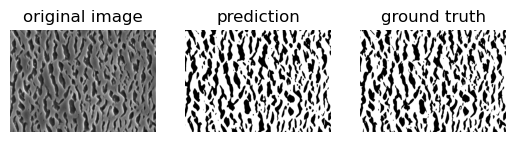

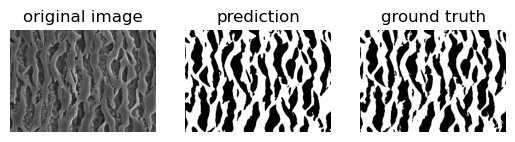

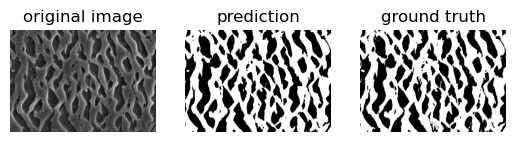

In [84]:
# inference.py

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.transforms import ToTensor

import segmentation_models_pytorch as smp
from utils.accuracy import accuracy_check
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

parser = argparse.ArgumentParser(description='sem img inference')

parser.add_argument('--data_root_path', type=str, default='./data/IN792sx/gamma/')
parser.add_argument('--image_path', type=str, default='./data/IN792sx/gamma/images/')
parser.add_argument('--mask_path', type=str, default='./data/IN792sx/gamma/annotations/')
parser.add_argument('--save_dir', type=str, default='./history/230719/IN792sx/resnet18_4_32/')
parser.add_argument('--model_path', type=str, default='./pretrained_model/')
parser.add_argument('--test', type=bool, default=True)

infer_args = parser.parse_args(list())



with open(os.path.join(infer_args.data_root_path, 'test.txt'), 'rb') as f:
    data_list = pickle.load(f)

save_dir = os.path.join(infer_args.save_dir, 'seg_result/')
print(save_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model = smp.DeepLabV3('resnet34', encoder_depth=4, encoder_weights=None, in_channels=1, decoder_channels=32)
model.load_state_dict(torch.load(os.path.join(infer_args.model_path, 'IN792sx_gamma_best.pt')))

model.cuda()

# test
total_acc = 0
toTensor = ToTensor() 
minmax_scaler = MinMaxScaler()
model.eval()

for data in data_list:
    data = data.split(' ')[0]

    img = Image.open(os.path.join(infer_args.image_path, data))
    img = toTensor(img).cuda().unsqueeze(0)

    with torch.no_grad():
        output = model(img)

    result = output[0][0].cpu().numpy()
    result[result < 0.5] = 0
    result[result >= 0.5] = 255

    palette = [0,0,0, 255,255,255]
    out = Image.fromarray(result.astype(np.uint8), mode='P')
    out.putpalette(palette)

    export_name = str(data)
    out.save(save_dir + export_name)

    if infer_args.test:
        msk = Image.open(os.path.join(infer_args.mask_path, data))
        msk = toTensor(msk).cuda().unsqueeze(0)

        mask_ori = msk[0][0].cpu().numpy()
        mask_ori[mask_ori < 0.5] = 0
        mask_ori[mask_ori >= 0.5] = 255

        

        mask = Image.fromarray(mask_ori.astype(np.uint8), mode='P')
        mask.putpalette(palette)

    
        acc = accuracy_check(mask_ori, out)
        total_acc += acc

        fig = plt.figure()
        rows = 1
        cols = 3

        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(img[0][0].cpu().numpy(), 'gray')
        ax1.set_title('original image')
        ax1.axis("off")

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(result.astype(np.uint8), 'gray')
        ax2.set_title('prediction')
        ax2.axis("off")

        ax3 = fig.add_subplot(rows, cols, 3)
        ax3.imshow(mask_ori, 'gray')
        ax3.set_title('ground truth')
        ax3.axis("off")

        export_name_fig = export_name[:-4] +'_fig.png'
        plt.savefig(save_dir + export_name_fig)


print('total_acc : ', total_acc/len(data_list))


### total data save

In [91]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.transforms import ToTensor

import segmentation_models_pytorch as smp
from utils.accuracy import accuracy_check
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

parser = argparse.ArgumentParser(description='sem img save')

parser.add_argument('--image_path', type=str, default='./data/IN792sx/gamma/images/')
parser.add_argument('--save_dir', type=str, default='./data/IN792sx/gamma/')
parser.add_argument('--model_path', type=str, default='./pretrained_model/')

save_args = parser.parse_args(list())

total_data_list = glob.glob(save_args.image_path + '*.*')

save_dir = os.path.join(save_args.save_dir, 'seg_result/')
print(save_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model = smp.DeepLabV3('resnet34', encoder_depth=4, encoder_weights=None, in_channels=1, decoder_channels=32)
model.load_state_dict(torch.load(os.path.join(save_args.model_path, 'IN792sx_gamma_best.pt')))

model.cuda()

# test
total_acc = 0
toTensor = ToTensor() 
minmax_scaler = MinMaxScaler()
model.eval()

for data in total_data_list:
    data = data.split(' ')[0]

    img = Image.open(data)
    img = toTensor(img).cuda().unsqueeze(0)

    with torch.no_grad():
        output = model(img)

    result = output[0][0].cpu().numpy()
    result[result < 0.5] = 0
    result[result >= 0.5] = 255

    palette = [0,0,0, 255,255,255]
    out = Image.fromarray(result.astype(np.uint8), mode='P')
    out.putpalette(palette)

    export_name = str(data.split('\\')[-1])
    out.save(save_dir + export_name)

./data/IN792sx/gamma/seg_result/


UnidentifiedImageError: cannot identify image file './data/IN792sx/gamma/images\\images.zip'